In [2]:
import pandas as pd
import json as json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
train = pd.read_csv("../data/train/train.csv")
train_id = train['PetID']
print(train.shape)

breeds = pd.read_csv("../data/breed_labels.csv")
print(breeds.shape)

colors = pd.read_csv("../data/color_labels.csv")
print(colors.shape)

states = pd.read_csv("../data/StateLabels.csv")
print(states.shape)



(14993, 24)
(307, 3)
(7, 2)
(15, 2)


In [13]:
train_id = train['PetID'][0:100]

doc_sent_mag = []
doc_sent_score = []
nf_count = 0
for pet in train_id:
    try:
        with open('../data/train_sentiment/' + pet + '.json', 'r', encoding='utf-8') as f:
            sentiment = json.load(f)
        doc_sent_mag.append(sentiment['documentSentiment']['magnitude'])
        doc_sent_score.append(sentiment['documentSentiment']['score'])
    except FileNotFoundError:
        nf_count += 1
        doc_sent_mag.append(-1)
        doc_sent_score.append(-1)

# train.loc[:, 'doc_sent_mag'] = doc_sent_mag
# train.loc[:, 'doc_sent_score'] = doc_sent_score


In [5]:
train_desc = train.Description.fillna("none").values


tfv = TfidfVectorizer(min_df=3, max_features=10000, strip_accents='unicode',
                     analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                     use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

# Fit the TF-IDF
tfv.fit(list(train_desc))
tfv_train =  tfv.transform(train_desc)
print("X (tfidf):", tfv_train.shape)

X (tfidf): (14993, 10000)


In [6]:
### Run in Google Colab (Load pickle model instead)

### Function taken from: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components



# tsvd = TruncatedSVD(n_components=tfv_train.shape[1]-1)
# TSVD_train = tsvd.fit(tfv_train)
# tsvd_var_ratios = tsvd.explained_variance_ratio_


In [7]:
import pickle

with open('../models/N-1 TSVD Model.p', 'rb') as fp:
    TSVD_train = pickle.load(fp)

C:\Users\Dell\miniconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
var_ratios = []
for i in range(101):
    var_ratios.append(select_n_components(TSVD_train.explained_variance_ratio_, ((i+1)/100)))

In [15]:
df_var = pd.DataFrame([list(range(101)), var_ratios]).transpose()
df_var.columns = ['variance_explained', 'n_components']
df_var

,variance_explained,n_components
0,0,2
1,1,3
2,2,4
3,3,7
4,4,9
...,...,...
96,96,5296
97,97,5779
98,98,6478
99,99,8856


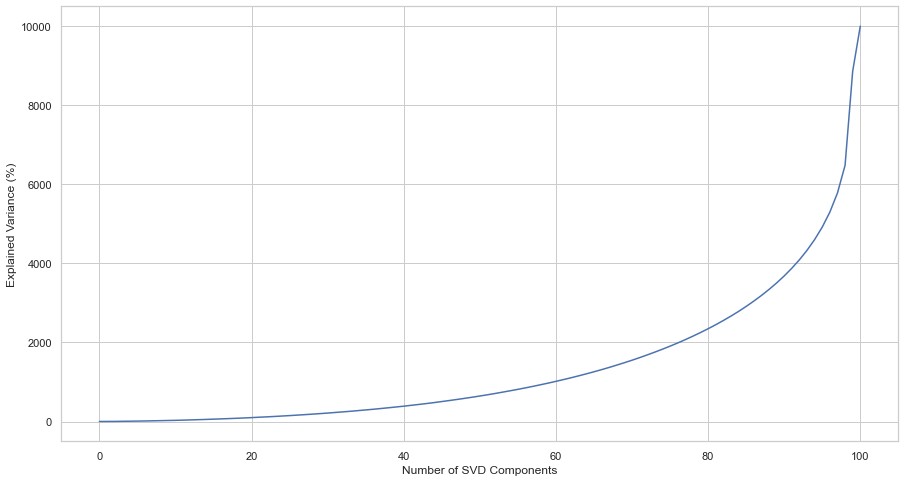

In [82]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=var_ratios, y=list(range(101)))
ax.set(xlabel='Number of SVD Components', ylabel='Explained Variance (%)')
plt.show()

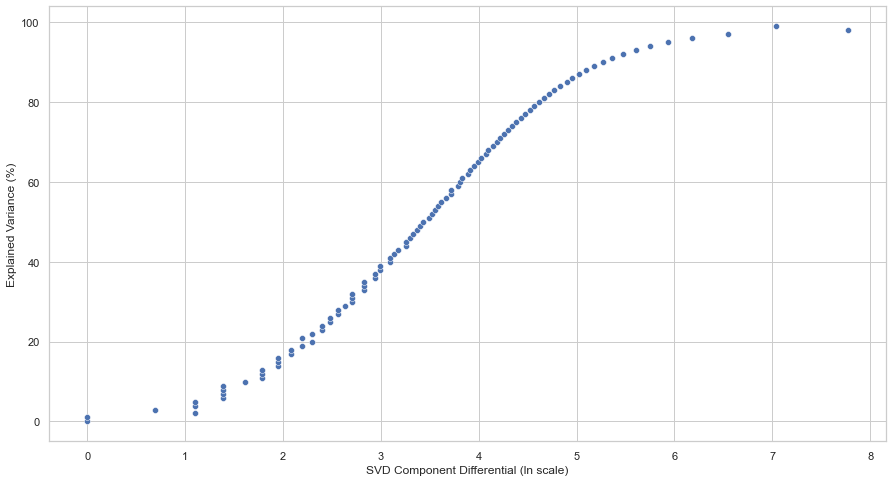

In [81]:
import numpy as np

plt.figure(figsize=(15,8))
ax = sns.scatterplot(x=np.log(np.diff(var_ratios)), y=list(range(100)))
ax.set(xlabel="SVD Component Differential (ln scale)", ylabel="Explained Variance (%)")
plt.show()

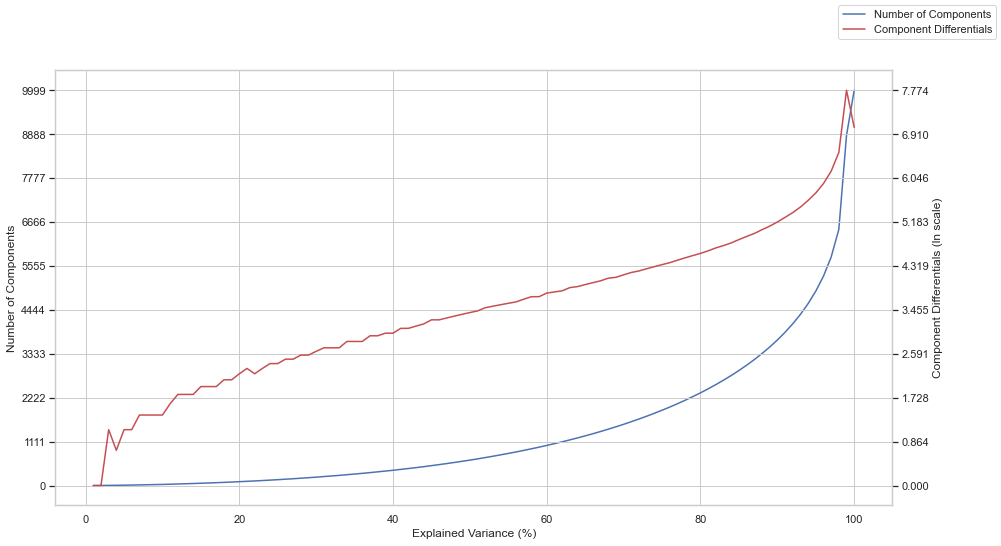

In [159]:
testplot = pd.DataFrame([var_ratios[1:], np.log(np.diff(var_ratios)), list(range(100))]).transpose()
testplot.columns = ['Number of Components', 'Component Differentials', 'Explained Variance (%)']
testplot['Explained Variance (%)'] = testplot['Explained Variance (%)']+1

plt.rcParams["figure.figsize"] = (15,8)
ax = testplot.plot(x="Explained Variance (%)", y="Number of Components", legend=False)
ax2 = ax.twinx()
testplot.plot(x="Explained Variance (%)", y="Component Differentials", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.set(ylabel="Number of Components")
ax2.set(ylabel="Component Differentials (ln scale)")
ax.set_yticks(np.linspace(0, 9999, 10))
ax2.set_yticks(np.linspace(0, max(testplot['Component Differentials']), 10))
plt.show()

In [ ]:

# Dimensionality Reduction of the TF-IDF Vectorizer
n_components=200
svd = TruncatedSVD(n_components=n_components)
svd.fit(X)
X = svd.transform(X)
print("X (svd):", X.shape)
print(svd.explained_variance_ratio_.sum())
print(svd.explained_variance_ratio_)

In [28]:
pd.DataFrame(X, columns=['svd_{}'.format(i) for i in range(n_components)])

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_190,svd_191,svd_192,svd_193,svd_194,svd_195,svd_196,svd_197,svd_198,svd_199
0,0.145085,-0.071665,-0.055382,-0.032234,-0.007677,-0.021383,-0.021633,-0.004157,-0.000708,0.011278,...,-0.022965,0.015197,-0.020991,0.072297,0.046424,0.022675,-0.080783,-0.018228,0.042301,-0.015983
1,0.088757,-0.047810,-0.017056,0.034882,-0.004573,-0.027038,-0.049449,0.041674,-0.015696,-0.024595,...,-0.022667,-0.033900,-0.051920,-0.015071,0.005680,0.009650,0.014763,-0.022524,0.027787,0.018626
2,0.137478,-0.074967,0.128756,0.001275,0.051886,-0.044999,0.211107,0.071929,-0.208622,-0.050373,...,-0.014879,-0.023028,-0.004853,0.016867,-0.031356,-0.021814,-0.014307,-0.017231,0.065357,0.035219
3,0.107927,-0.052213,-0.013401,0.129699,0.000417,0.040912,0.082158,-0.024573,-0.006301,-0.020177,...,-0.026057,-0.002859,-0.008901,0.025478,-0.015137,-0.017642,-0.002386,0.062460,0.000451,0.026677
4,0.184415,-0.010609,-0.009677,0.036700,-0.038518,0.030425,-0.068261,-0.071432,-0.057374,-0.075393,...,-0.015239,-0.007812,-0.021296,0.019753,0.033791,-0.030902,-0.017215,0.031161,-0.029029,-0.019537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,0.198140,-0.090404,-0.042914,-0.127398,0.031410,-0.093508,-0.007050,-0.026960,0.071623,-0.008153,...,-0.032493,0.050469,-0.027955,-0.002451,-0.051714,-0.028466,0.023505,0.001128,0.029301,-0.072457
14989,0.163456,-0.069442,-0.062389,-0.071045,-0.004157,-0.067195,-0.023582,-0.003589,0.058514,0.006572,...,0.007635,0.014863,-0.039316,-0.025488,-0.008387,-0.022455,0.034846,0.033524,-0.000245,0.021566
14990,0.123988,-0.056339,-0.051388,0.059897,-0.039614,0.066679,0.037513,-0.008385,0.026587,0.142696,...,0.011238,-0.018956,0.045256,-0.014465,-0.009204,0.014842,0.040246,-0.032293,0.024037,0.034606
14991,0.061709,-0.033306,-0.027851,0.023997,-0.036314,0.031650,-0.036204,0.019704,-0.019442,-0.012541,...,0.027683,-0.012663,0.026863,0.041418,-0.001745,0.003946,0.015252,0.001824,0.023000,-0.021003
